In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [10]:
df = pd.read_csv('C:/Users/PC1/Downloads/archive/Shopify.csv')

In [11]:
print(df.head()) #7 columns, including the Date.

         Date       Open       High        Low      Close  Adj Close    Volume
0  2015-05-20  17.000000  17.000000  17.000000  17.000000  17.000000         0
1  2015-05-21  28.000000  28.740000  24.110001  25.680000  25.680000  12303900
2  2015-05-22  26.070000  31.100000  26.000000  28.309999  28.309999   2841200
3  2015-05-26  29.799999  30.340000  29.080000  29.650000  29.650000    820200
4  2015-05-27  30.670000  30.809999  27.000000  27.500000  27.500000    797600


In [12]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. / 

1751   2022-05-03
1752   2022-05-04
1753   2022-05-05
1754   2022-05-06
1755   2022-05-09
1756   2022-05-10
1757   2022-05-11
1758   2022-05-12
1759   2022-05-13
1760   2022-05-16
1761   2022-05-17
1762   2022-05-18
1763   2022-05-19
1764   2022-05-20
1765   2022-05-23
Name: Date, dtype: datetime64[ns]


In [13]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [14]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

In [15]:
df_for_training.head(10000)

,Open,High,Low,Close,Adj Close
0,17.000000,17.000000,17.000000,17.000000,17.000000
1,28.000000,28.740000,24.110001,25.680000,25.680000
2,26.070000,31.100000,26.000000,28.309999,28.309999
3,29.799999,30.340000,29.080000,29.650000,29.650000
4,30.670000,30.809999,27.000000,27.500000,27.500000
...,...,...,...,...,...
1761,374.007996,384.970001,346.381989,372.640015,372.640015
1762,363.059998,379.730011,355.019989,360.619995,360.619995
1763,362.160004,413.700012,360.500000,391.329987,391.329987
1764,400.690002,403.989990,340.010010,363.850006,363.850006


In [16]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [17]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [18]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

trainX shape == (1752, 14, 5).
trainY shape == (1752, 1).


In [19]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
99/99 [==============================] - 5s 16ms/step - loss: 0.0841 - val_loss: 0.1102
Epoch 2/5
99/99 [==============================] - 1s 10ms/step - loss: 0.0336 - val_loss: 0.0396
Epoch 3/5
99/99 [==============================] - 1s 10ms/step - loss: 0.0309 - val_loss: 0.0320
Epoch 4/5
99/99 [==============================] - 1s 10ms/step - loss: 0.0263 - val_loss: 0.0242
Epoch 5/5
99/99 [==============================] - 1s 10ms/step - loss: 0.0239 - val_loss: 0.0272


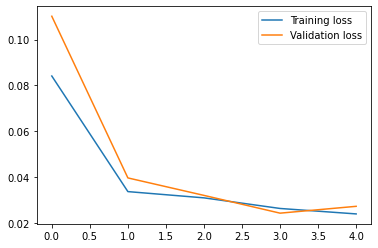

In [20]:
# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [21]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [40]:
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days


In [41]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)


[Timestamp('2022-05-02 00:00:00', freq='C'), Timestamp('2022-05-03 00:00:00', freq='C'), Timestamp('2022-05-04 00:00:00', freq='C'), Timestamp('2022-05-05 00:00:00', freq='C'), Timestamp('2022-05-06 00:00:00', freq='C'), Timestamp('2022-05-09 00:00:00', freq='C'), Timestamp('2022-05-10 00:00:00', freq='C'), Timestamp('2022-05-11 00:00:00', freq='C'), Timestamp('2022-05-12 00:00:00', freq='C'), Timestamp('2022-05-13 00:00:00', freq='C'), Timestamp('2022-05-16 00:00:00', freq='C'), Timestamp('2022-05-17 00:00:00', freq='C'), Timestamp('2022-05-18 00:00:00', freq='C'), Timestamp('2022-05-19 00:00:00', freq='C'), Timestamp('2022-05-20 00:00:00', freq='C')]


In [42]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [43]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


C:\Users\PC1\AppData\Local\Temp\ipykernel_4512\1604274314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


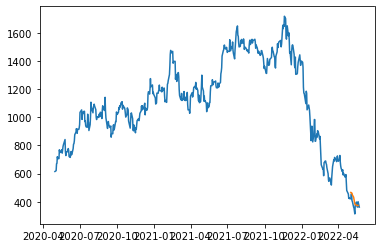

In [44]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']
plt.plot(original['Date'], original['Open'])
plt.plot(df_forecast['Date'], df_forecast['Open'])